# **Import Libraries**

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [14]:
base_path = '/kaggle/input/eurosat-dataset/EuroSAT'

In [15]:
# Create a folder to save all checkpoints
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

# **Load CSVs**

In [17]:
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
val_df   = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df  = pd.read_csv(os.path.join(base_path, 'test.csv'))

train_df['Filename'] = train_df['Filename'].apply(lambda x: os.path.join(base_path, x.strip()))
val_df['Filename']   = val_df['Filename'].apply(lambda x: os.path.join(base_path, x.strip()))
test_df['Filename']  = test_df['Filename'].apply(lambda x: os.path.join(base_path, x.strip()))

# **Exploratory Data Analysis**

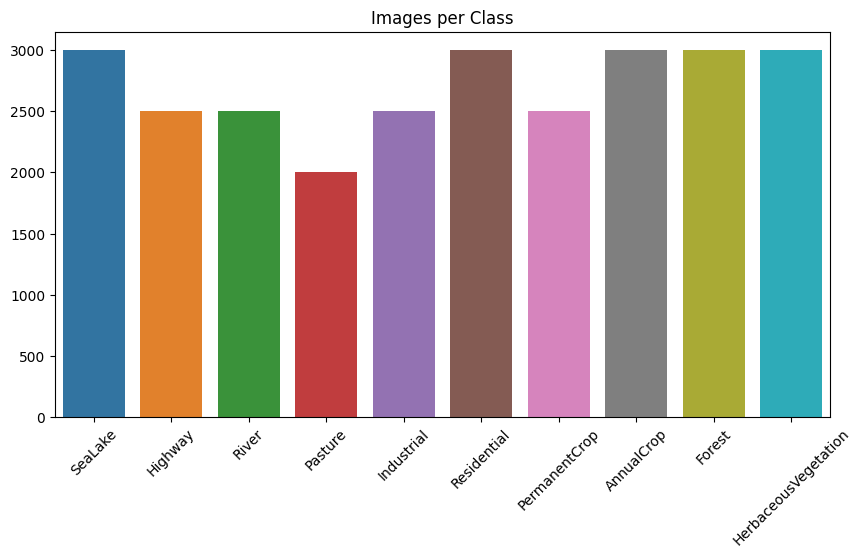

In [5]:
# Count images per class
class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))] 
class_counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in class_dirs}

plt.figure(figsize=(10, 5))

# Convert x to pd.Series; Removes warning of seaborn (Array)
sns.barplot(
    x=pd.Series(list(class_counts.keys())),
    y=list(class_counts.values())
)

plt.xticks(rotation=45)
plt.title("Images per Class")
plt.show()

# **Image Generators**

In [18]:
img_height, img_width = 224, 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filename',
    y_col='ClassName',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filename',
    y_col='ClassName',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filename',
    y_col='ClassName',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


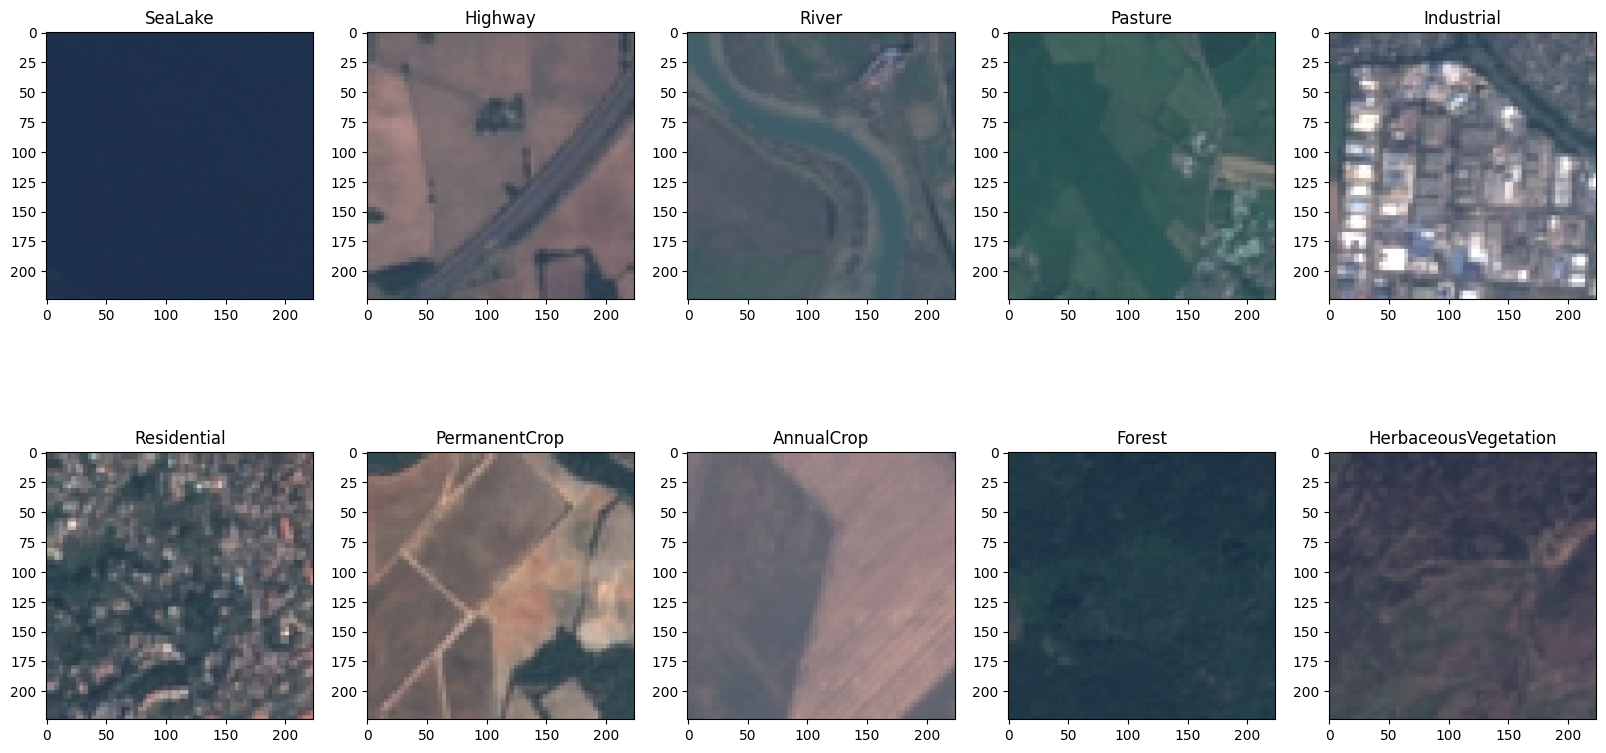

In [7]:
plt.figure(figsize=(20, 10))

for i, cls in enumerate(class_dirs[:10]):
    folder = os.path.join(base_path, cls)
    image_file = random.choice([f for f in os.listdir(folder) if f.endswith(('.jpg', '.png'))])
    img_path = os.path.join(folder, image_file)
    img = load_img(img_path, target_size=(224, 224))

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(cls)  
    
plt.show()

# **Early Stop Block**

In [6]:
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=10,               # stop after 10 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# **CNN Model**

In [9]:
num_classes = len(train_generator.class_indices)

#Define
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

#Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

I0000 00:00:1751406345.988447      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751406345.989264      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751406350.085193     102 service.cc:148] XLA service 0x7804b4006f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751406350.086227     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751406350.086248     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751406350.432654     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/591 ━━━━━━━━━━━━━━━━━━━━ 1:20:26 8s/step - accuracy: 0.2188 - loss: 2.2839

I0000 00:00:1751406355.832102     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


591/591 ━━━━━━━━━━━━━━━━━━━━ 131s 208ms/step - accuracy: 0.3273 - loss: 1.8485 - val_accuracy: 0.6411 - val_loss: 1.0327
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.6000 - loss: 1.1260 - val_accuracy: 0.6998 - val_loss: 0.8722
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.6905 - loss: 0.8783 - val_accuracy: 0.7293 - val_loss: 0.7467
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.7526 - loss: 0.6905 - val_accuracy: 0.7935 - val_loss: 0.5876
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.8144 - loss: 0.5333 - val_accuracy: 0.7924 - val_loss: 0.6150
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.8496 - loss: 0.4301 - val_accuracy: 0.8248 - val_loss: 0.5107
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - accuracy: 0.8736 - loss: 0.3584 - val_accuracy: 0.8020 - val_loss: 0.6539
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - accuracy: 0.9020 - loss: 0.2921 - val_accur

### *CheckPoint*

In [10]:
# Save model to this directory
model.save(os.path.join(save_path_checkpoints, "custom_model.keras"))

### *Classification report*

In [11]:
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step
                      precision    recall  f1-score   support

          AnnualCrop       0.85      0.89      0.87       600
              Forest       0.89      0.98      0.93       600
HerbaceousVegetation       0.82      0.63      0.71       600
             Highway       0.63      0.73      0.68       500
          Industrial       0.94      0.86      0.90       500
             Pasture       0.85      0.68      0.76       400
       PermanentCrop       0.62      0.78      0.69       500
         Residential       0.93      0.95      0.94       600
               River       0.76      0.72      0.74       500
             SeaLake       0.96      0.95      0.96       600

            accuracy                           0.82      5400
           macro avg       0.83      0.82      0.82      5400
        weighted avg       0.83      0.82      0.82      5400



### *Performance Analysis*

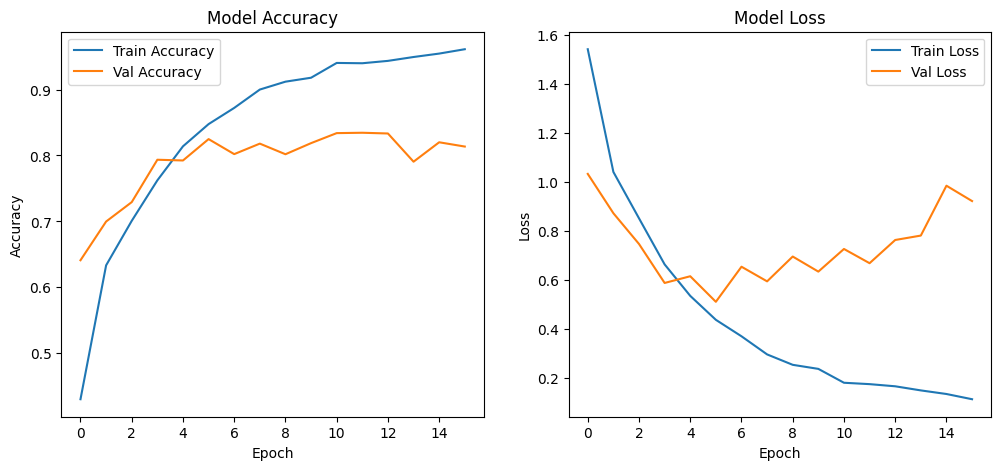

In [12]:
# Accuracy and Loss over Epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### *Confusion Matrix*

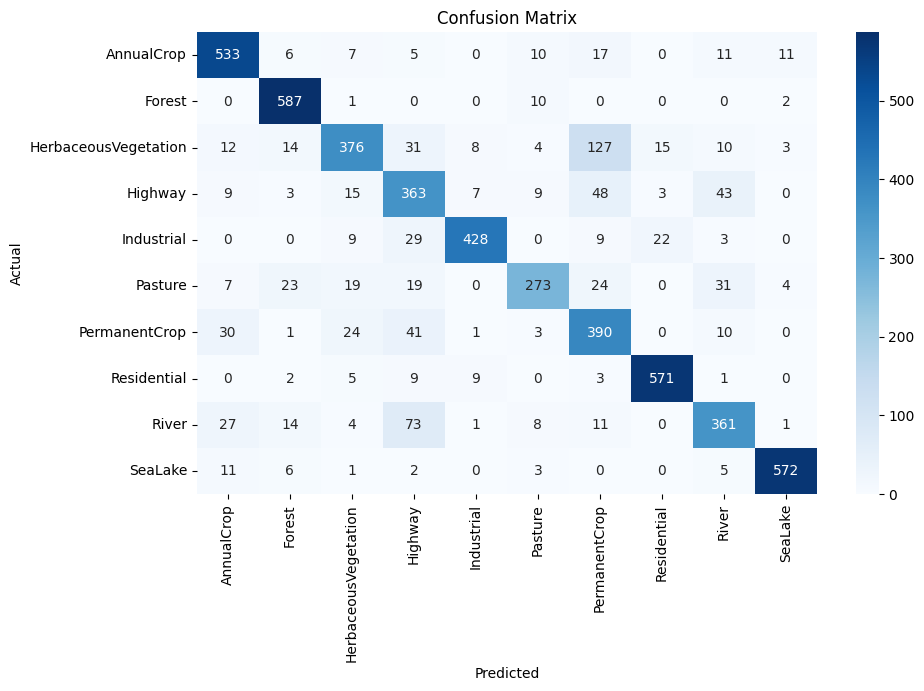

In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **Pretrained CNN ResNet50**

In [14]:

SEED = 42
tf.random.set_seed(SEED)

# Image size required for ResNet
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Update your datagen preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='Filename', y_col='ClassName', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)
val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col='Filename', y_col='ClassName', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

# Define 
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

resnet_model = models.Sequential([
    resnet_base,                                                               # Pretrained ResNet50 feature extractor
    layers.GlobalAveragePooling2D(),                                           # Reduces feature maps to a flat vector
    layers.Dense(128, activation='relu'),                                      # Fully connected layer to learn patterns 
    layers.Dropout(0.5),                                                       # Helps prevent overfitting
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train 
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 ━━━━━━━━━━━━━━━━━━━━ 102s 146ms/step - accuracy: 0.5725 - loss: 1.3137 - val_accuracy: 0.9169 - val_loss: 0.2767
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 72s 123ms/step - accuracy: 0.8838 - loss: 0.3746 - val_accuracy: 0.9394 - val_loss: 0.1994
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 71s 120ms/step - accuracy: 0.9057 - loss: 0.2782 - val_accuracy: 0.9459 - val_loss: 0.1683
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 71s 121ms/step - accuracy: 0.9251 - loss: 0.2274 - val_accuracy: 0.9498 - val_loss: 0.1515
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 72s 121ms/step - accuracy: 0.9312 - loss: 0.2068 - val_accuracy: 0.9556 - val_loss: 0.1394
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 71s 120ms/step - accuracy: 0.9412 - loss: 0.1805 - val_accuracy: 0.9550 - val_loss: 0.1303
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 71s 120ms/step - accuracy: 0.9490 - loss: 0.1586 - val_accuracy: 0.9580 - val_loss: 0.1222
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 71s 120ms/step - accuracy: 0.9492 - loss: 0.1547 - va

### *CheckPoint*

In [15]:
# Save model to this directory
model.save(os.path.join(save_path_checkpoints, "pretrained_model.keras"))

# **ANN Model**

In [ ]:
# Set image dimensions
img_height, img_width = 8, 8
input_shape_flat = img_height * img_width * 3

# Get number of classes from generator
num_classes = len(train_generator.class_indices)

# Define ANN model
ann_model = models.Sequential([
    layers.Input(shape=(input_shape_flat,)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
ann_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Flatten generator output
def flatten_generator(generator):
    X, y = [], []
    for batch_x, batch_y in generator:
        batch_flat = batch_x.reshape(batch_x.shape[0], -1)
        X.append(batch_flat)
        y.append(batch_y)
        if len(X) * batch_x.shape[0] >= generator.samples:
            break
    return np.vstack(X), np.vstack(y)

# Prepare training and validation data
X_train_ann, y_train_ann = flatten_generator(train_generator)
X_val_ann, y_val_ann = flatten_generator(val_generator)

# Train ANN
ann_history = ann_model.fit(
    X_train_ann, y_train_ann,
    validation_data=(X_val_ann, y_val_ann),
    epochs=50,
    callbacks=[early_stop]
)


I0000 00:00:1751410910.149492    1507 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751410910.150145    1507 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### *CheckPoint*

In [ ]:
# Save model to this directory
ann_model.save(os.path.join(save_path_checkpoints, "ann_model.keras"))

# **Performance Comparison: ANN, CCNN-Custom, CNN-Pretrained**

In [8]:
# For Pretrained CNN
test_generator_resnet = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    test_df, x_col='Filename', y_col='ClassName',
    target_size=(224, 224), class_mode='categorical',
    batch_size=32, shuffle=False
)

# For Custom CNN
test_generator_custom = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df, x_col='Filename', y_col='ClassName',
    target_size=(224, 224), class_mode='categorical',
    batch_size=32, shuffle=False
)

Found 2700 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


In [11]:
# Accuracy values
#ann_val_acc = ann_history.history['val_accuracy'][-1] * 100
custom_acc = custom_score[1] * 100
resnet_acc = resnet_score[1] * 100

# Print all
#print(f"ANN Validation Accuracy: {ann_val_acc:.2f}%")
print(f"Custom CNN Test Accuracy: {custom_acc:.2f}%")
print(f"ResNet50 Test Accuracy: {resnet_acc:.2f}%")

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Custom CNN (Test)', 'ResNet50 (Test)'],
        [ann_val_acc, custom_acc, resnet_acc],
        color=['skyblue', 'salmon'])

plt.ylabel('Accuracy (%)')
plt.title('CNN vs ResNet50')
plt.show()


NameError: name 'custom_score' is not defined